In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        data = pd.read_csv(data_path).values
        self.labels = data[:, 0]                                     # (n, 1)
        self.pixels = data[:, 1:].reshape(data.shape[0], 1, 28, 28)  # (n, 1, 28, 28)
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return (self.pixels[idx], self.labels[idx])

In [3]:
dataset = MNISTDataset('../train.csv')
print(len(dataset))

TRAIN_VAL_SPLIT = 0.8
TRAIN_SIZE = int(TRAIN_VAL_SPLIT * len(dataset))
VAL_SIZE = len(dataset) - TRAIN_SIZE

train_set, val_set = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_set))
print(len(val_set))

42000
33600
8400


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(30, 15, 3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear((28 // 2 // 2)**2 * 15, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = F.softmax(x, dim=1)
        return output
    
    def loss(self, output, label):
        loss = F.cross_entropy(output, label)
        return loss

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    print("Epoch %d" % epoch)
    model.train()
    losses = []
    
    # iterate batch
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device = device, dtype = torch.float)
        label = label.to(device = device, dtype = torch.long)

        # reset gradients
        optimizer.zero_grad()
        
        # make prediction
        output = model(data)
        
        # compute error gradients
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # print loss every 21 batch iterations
        if i % 21 == 0:
            print("Batch Iteration %d, Train Loss: %.6f" % (i, loss.item()))
    
    return losses


def validate(model, device, val_loader):
    model.eval()
    losses = []
    
    correct = 0
    with torch.no_grad():
        for (data, label) in val_loader:
            data = data.to(device = device, dtype = torch.float)
            label = label.to(device = device, dtype = torch.long)
            output = model(data)
            loss = model.loss(output, label)
            losses.append(loss.item())
            
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
    val_loss = np.mean(losses)

    print("\nValidation Loss: {}, Accuracy: {}/{} ({:.0f}%)\n".format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return losses, val_loss

Using: cuda
Epoch 1
Batch Iteration 0, Train Loss: 2.318812
Batch Iteration 21, Train Loss: 2.159754
Batch Iteration 42, Train Loss: 2.174551
Batch Iteration 63, Train Loss: 2.195589
Batch Iteration 84, Train Loss: 2.110502
Batch Iteration 105, Train Loss: 2.149657
Batch Iteration 126, Train Loss: 2.164715
Batch Iteration 147, Train Loss: 2.129966

Validation Loss: 2.0665493664287387, Accuracy: 3305/8400 (39%)

Epoch 2
Batch Iteration 0, Train Loss: 1.990875
Batch Iteration 21, Train Loss: 1.863994
Batch Iteration 42, Train Loss: 1.818491
Batch Iteration 63, Train Loss: 1.711828
Batch Iteration 84, Train Loss: 1.749415
Batch Iteration 105, Train Loss: 1.757572
Batch Iteration 126, Train Loss: 1.726681
Batch Iteration 147, Train Loss: 1.671935

Validation Loss: 1.605217687430836, Accuracy: 7185/8400 (86%)

Epoch 3
Batch Iteration 0, Train Loss: 1.625230
Batch Iteration 21, Train Loss: 1.551403
Batch Iteration 42, Train Loss: 1.637623
Batch Iteration 63, Train Loss: 1.534793
Batch Iterat

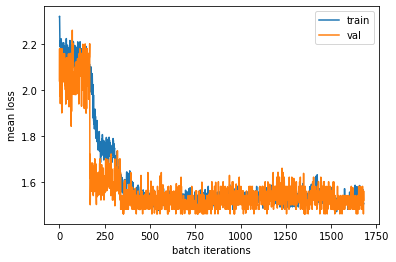

In [7]:
# hyperparameters
EPOCHS = 10
TRAIN_BATCH_SIZE = 200
VAL_BATCH_SIZE = 50

# hardware device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: %s" % device)
kwargs = {'num_workers': 0,
          'pin_memory': True} if use_cuda else {}

# data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = TRAIN_BATCH_SIZE,
                                           shuffle = True, drop_last = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = VAL_BATCH_SIZE,
                                          shuffle = False, drop_last = True, **kwargs)  

# training objects
model = CNN().to(device)
optimizer = optim.Adam(model.parameters())

# training loop
train_curve = []
val_curve = []
best_loss = np.inf
for epoch in range(1, EPOCHS + 1):
    train_losses = train(model, device, train_loader, optimizer, epoch)
    val_losses, val_loss = validate(model, device, val_loader)
    train_curve.extend(train_losses)
    val_curve.extend(val_losses)
    
    # save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/epoch_%d.pt" % epoch)
        
# plot loss functions
plt.plot(np.arange(EPOCHS * 168) + 1, train_curve, label = "train")
plt.plot(np.arange(EPOCHS * 168) + 1, val_curve, label = "val")
plt.legend()
plt.xlabel('batch iterations')
plt.ylabel('mean loss')
plt.show()